# Deep Convolutional Generative Adversarial Networks with TensorFlow

This is the report and code (Jupyter notebook) for the second homework of the course "Selected Topics in Visual Recognition in Deep Learning"

Student: Fu-sung Kim-Benjamin Tang
Student-ID: 0845058

# Github Link for the repository: 
https://github.com/kimbold/VRDL_2019


# Brief introduction:
For this homework we had to download the celebrity dataset and then train a Generative Adversarial Network on it to generate 500 different 3x3 images with faces (so 9 faces per image). 

For this a generator, which will generate the faces and a discrimantor, which will discriminate between real images and generated ones, are required.
The idea basically two networks are trained to work together and the generator becomes increasingly better at generating realisticly looking faces whereas the disriminator becomes better as differentiating between generated ones and real ones. By doing so, both systems will improve and end up creating quite realistic faces (hopefully). 

This notebook was executed on Google colab and I established a connection with my drive to store the images there. If it is not executed in google colab, the lines for that have to be removed/commented.

# Methodology:

**Preprocessing:**


*   Load images with data helper
*   Define method to get batches from image data
*   Define inputs for network


**Model architecture:**

* Generator network with 4 convolutional tensorflow layers
* Discriminator network with 4 convolutional tensorflow layers
* Data input configured for image size (56x56)

**Hyperparamters:**

*Images:*
*   Image height/width = 56x56
*   Colormode = RGB

*Networks:*
* batch_size = 16
* z_dim = 100
* learning_rate = 0.0002
* beta1 = 0.5
* epochs = 20
* alpha=0.2
* label_smoothing = 0.9
* leaky ReLu
* 4 convolutional layers

# Findings/Summary:

Its my first time experimenting with a Generative Adversial Network and also to generate faces, so it was surprising how well it worked, since most generated faces look not too bad. But it is notable that in almost every image with the 9 faces, at least one looks really off/is poorly generated. There is definitely a lot that could be improved but I tried to increase the number of epochs just to find out, that at around 35 the performance suddenly drops heavily. 
It looked like the GAN suddenly forgot everything and started generating really bad faces. So I assume that there is a point until training it with more epochs improves performances until it degrades it. So early stopping would be a measurement to prevent this in the future. 










## Setup



1.   Get helper method for dataset download from my github repository
1.   Import required modules together with helper
2.   Download and extract celeb dataset into data folder
3. Define methods to get images (as matrices) and data as batches 
4. Define network input, discriminator, generator, loss function and optimization
5. Train
6. After model is finished with training, use it together with the output method to create 500 images with 3x3 generated images on them as required by the homework





Used Libraries:
* matplotlib
* PIL / Pillow
* numpy
* requests
* tqdm
* TensorFlow

In [1]:
!git clone https://github.com/kimbold/VRDL_2019

Cloning into 'VRDL_2019'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 3885 (delta 1), reused 16 (delta 0), pack-reused 3865
Receiving objects: 100% (3885/3885), 52.45 MiB | 56.65 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import os
import VRDL_2019.HW2.helper as helper
import matplotlib.pyplot as plt
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np

data_dir = './data'
helper.download_extract(data_dir)

show_n_images = 9
image_size = 56
plt.figure(figsize=(10, 10))
images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], image_size, image_size, 'RGB')
#plt.imshow(helper.images_square_grid(images))
#plt.show()
print(images.shape)

Extracting celeba...
(9, 56, 56, 3)


<Figure size 720x720 with 0 Axes>

## The CelebA Dataset

shape: (202599, 56, 56, 3)


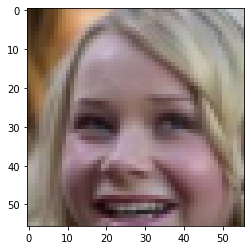

In [3]:
%matplotlib inline
# Image configuration with height, width and storage location
IMAGE_HEIGHT = 56
IMAGE_WIDTH = 56
data_files = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

print("shape:", shape)

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array([get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
  #print("Hello")
  IMAGE_MAX_VALUE = 255
  current_index = 0

  while current_index + batch_size <= shape[0]:
        #print(shape[0])
        data_batch = get_batch(data_files[current_index:current_index + batch_size],*shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5
        

#test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
pyplot.imshow(get_image("data/img_align_celeba/006917.jpg", IMAGE_WIDTH, IMAGE_HEIGHT, 'RGB'))

In [4]:
# Now get all images with the define properties
show_n_images = 9
image_size = 56
plt.figure(figsize=(10, 10))
images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], image_size, image_size, 'RGB')
#plt.imshow(helper.images_square_grid(images))
#plt.show()
print(images.shape)

(9, 56, 56, 3)


<Figure size 720x720 with 0 Axes>

## Defining network input

Before defining the two networks, the inputs must be defined. TensorFlow Placeholders for the real and fake inputs and for the learning rate are going to be defined.

In [ ]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

## The discriminator network

The discriminator distinguishes between real and generated images. In essence it is a convolutional neural network for image classification. The discriminator network consists of convolutional layers and for every layer of the network, a convolution, a batch normalization to make the network faster and more accurate and finally a Leaky ReLu are going to be performed.

In [0]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        # Conv 4
        conv4 = tf.layers.conv2d(lrelu3, 512, 5, 1, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
       
        # Flatten
        flat = tf.reshape(lrelu4, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

## The generator network

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of four deconvolutional layers. In here, we are doing the same as in the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [0]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)

        # Deconv 3
        deconv5 = tf.layers.conv2d_transpose(lrelu4, 64, 5, 2, padding='SAME')
        batch_norm5 = tf.layers.batch_normalization(deconv5, training=is_train)
        lrelu5 = tf.maximum(alpha * batch_norm5, batch_norm5)

        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu5, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

## Loss Functions

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [0]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

## Optimization

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Visualization


In the last step of our preparation, we are writing a small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [0]:
def output_fig(images_array, file_name="./results"):
  pyplot.figure(figsize=(6,6), dpi=100)
  pyplot.imshow(helper.images_square_grid(images_array))
  pyplot.axis("off")
  pyplot.savefig(file_name+".png", bbox_inches='tight', pad_inches=0)

def show_generator_output(sess, n_images, input_z, out_channel_dim, save_option, id):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
  
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    if(save_option==True):
      file_name="{:03d}".format(id)
      output_fig(samples, file_name=file_name)
      uploaded = drive.CreateFile({'title': file_name+".png"})
      uploaded.SetContentFile(file_name+".png")
      uploaded.Upload()
      print('Uploaded file with ID {}'.format(uploaded.get('id')))
    else:
      pyplot.imshow(helper.images_square_grid(samples))
      pyplot.show()

## Training

Now by using the inputs, losses and optimizers as defined before, a TensorFlow session will be called and executed batch by batch. Every 400 steps the current progress will be printed out by showing the generated image and loss.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print("Epoch:", epoch_i, "/", epoch_count)
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   
                    _ = show_generator_output(sess, 9, input_z, data_shape[3], False, 0)

        for x in range(500):
           _ = show_generator_output(sess, 9, input_z, data_shape[3], True, x)     

In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 20

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#directory="GeneratedImages"
#if not os.path.exists(directory):
#    os.makedirs(directory)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)